## Proyecto Final - Deep Learning para Series Temporales
### Clasificación de Actividad Cerebral Dañina (EEG) - HMS Challenge

La electroencefalografía (EEG) es una herramienta fundamental en el monitoreo de la actividad cerebral de pacientes críticamente enfermos. Detectar patrones anómalos como convulsiones y descargas anormales de manera rápida y precisa es esencial para brindar un tratamiento oportuno.

En este proyecto, abordamos el problema de clasificación de actividad cerebral dañina utilizando señales EEG del desafío HMS (Harmful Brain Activity Classification).

El objetivo principal es desarrollar un modelo de Deep Learning capaz de distinguir entre señales cerebrales normales y señales que representan actividad dañina, inicialmente enfocándonos en la detección de convulsiones (problema binario).

Posteriormente, se sugiere la extensión del modelo para abarcar la clasificación multiclase de distintos patrones dañinos, como GPD, LPD, LRDA, GRDA y otros.

In [ ]:
# A raiz de una series de inconvenientes presentado con el equipo utilizado para las 
# pruebas y la GPU RTX 3070 mas el uso exagerado de memoria RAM, tuve que implementar 
# algunas confdiguraciones las cuales coloque en este bloque mas en codigo siguiente. 
import os
import warnings

# Silenciar warnings de TensorFlow y SciKit-Learn
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Oculta INFO y WARNING de TensorFlow
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Desactiva optimizaciones oneDNN si molestan

warnings.filterwarnings("ignore")  # Silencia cualquier warning de sklearn, etc.


# Importar librerías necesarias
import pandas as pd
import numpy as np
import gc
import glob
import logging
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from scipy.signal import butter, filtfilt
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.exceptions import UndefinedMetricWarning

# Configurar logging y silenciar warnings específicos
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Habilitar precisión mixta para optimizar el uso de la GPU
policy = Policy('mixed_float16')
set_global_policy(policy)

# Verificar GPU
print("Dispositivos físicos disponibles:", tf.config.list_physical_devices())
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

# Cargar archivo principal
DATA_DIR = 'data'
EEG_DIR = os.path.join(DATA_DIR, 'train_eegs')
TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
train_df = pd.read_csv(TRAIN_CSV)
OUTPUT_DIR = 'processed_data'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Mostrar las primeras filas
print(train_df.head())


2025-04-17 10:33:06.538286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744878786.598589    4245 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744878786.615864    4245 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744878786.747272    4245 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744878786.747290    4245 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744878786.747291    4245 computation_placer.cc:177] computation placer alr

Dispositivos físicos disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                

### Análisis Exploratorio de Datos (EDA)

Análisis rápido
Muestro como esta el balance del dataset

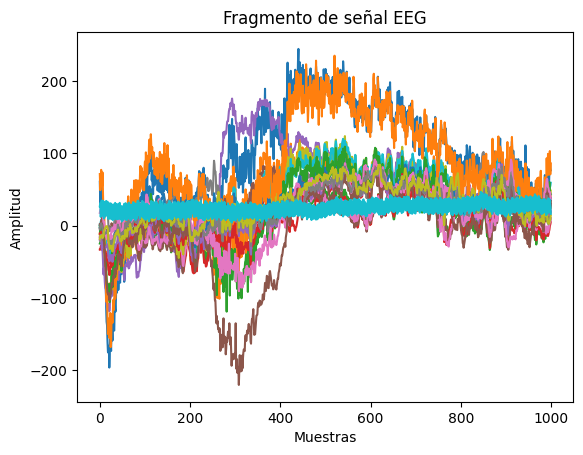

In [ ]:
# Mostrar una señal EEG aleatoria
example_eeg_file = glob.glob(os.path.join(EEG_DIR, '*.parquet'))[0]
eeg_data = pq.read_table(example_eeg_file).to_pandas()

plt.plot(eeg_data.iloc[:1000].values)
plt.title('Fragmento de señal EEG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()


### Preparación de Datos y Reducción de Dimensionalidad con Autoencoder

In [ ]:
# Función para filtro de paso de banda
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=200):
    b, a = butter_bandpass(lowcut, highcut, fs)
    try:
        filtered = filtfilt(b, a, data, axis=0)
        if np.any(np.isnan(filtered)) or np.any(np.isinf(filtered)):
            logger.warning("Filtro generó NaN o inf")
            return data
        return filtered
    except Exception as e:
        logger.error(f"Error en filtro: {e}")
        return data

# Función para aumento de datos
def augment_signal(signal, noise_factor=0.01, shift_max=50):
    if np.random.rand() < 0.3:
        noise = np.random.normal(0, noise_factor, signal.shape)
        signal = signal + noise
    if np.random.rand() < 0.3:
        shift = np.random.randint(-shift_max, shift_max)
        signal = np.roll(signal, shift, axis=0)
    return signal


print(f"Número de registros en train.csv: {len(train_df)}")

# Listado de EEGs disponibles
available_eeg_files = glob.glob(os.path.join(EEG_DIR, '*.parquet'))
available_eeg_ids = set([int(os.path.basename(f).split('.')[0]) for f in available_eeg_files])
print(f"Número de EEGs disponibles: {len(available_eeg_ids)}")

# Filtrado de registros
train_df = train_df[train_df['eeg_id'].isin(available_eeg_ids)].reset_index(drop=True)
print(f"Registros después de filtrar EEGs disponibles: {len(train_df)}")

# Procesamiento por lotes
batch_size = 50
batch_X = []
batch_y = []
batch_count = 0
file_count = 0
segment_indices = []

for eeg_id in train_df['eeg_id'].unique():
    eeg_file = os.path.join(EEG_DIR, f'{eeg_id}.parquet')
    
    if not os.path.exists(eeg_file):
        logger.warning(f"Archivo no encontrado: {eeg_file}")
        continue

    try:
        logger.info(f"Procesando EEG ID: {eeg_id}")
        eeg_data = pq.read_table(eeg_file).to_pandas()
        
        if eeg_data.empty or not np.all(np.isfinite(eeg_data.values)):
            logger.warning(f"Datos inválidos en EEG ID: {eeg_id}")
            continue

        with tf.device('/GPU:0'):
            eeg_data = tf.convert_to_tensor(eeg_data.values, dtype=tf.float32)
            eeg_data = tf.py_function(func=bandpass_filter, inp=[eeg_data], Tout=tf.float32)

        subset = train_df[train_df['eeg_id'] == eeg_id]

        for _, row in subset.iterrows():
            start_time = int(row['eeg_label_offset_seconds'])
            start_idx = start_time * 200
            end_idx = start_idx + 6 * 200

            if end_idx > eeg_data.shape[0]:
                logger.warning(f"Segmento fuera de rango para EEG ID: {eeg_id}")
                continue

            signal_slice = eeg_data[start_idx:end_idx]
            with tf.device('/GPU:0'):
                for ch in range(signal_slice.shape[1]):
                    std = tf.math.reduce_std(signal_slice[:, ch])
                    mean = tf.math.reduce_mean(signal_slice[:, ch])
                    signal_slice = tf.tensor_scatter_nd_update(
                        signal_slice,
                        [[i, ch] for i in range(signal_slice.shape[0])],
                        tf.where(std == 0, 0.0, (signal_slice[:, ch] - mean) / (std + 1e-6))
                    )

                signal_slice = tf.py_function(func=augment_signal, inp=[signal_slice], Tout=tf.float32)

            batch_X.append(signal_slice.numpy())
            label = 1 if row['seizure_vote'] > 0 else 0
            batch_y.append(label)
            segment_indices.append((batch_count, len(batch_X)-1, label))

            if len(batch_X) >= batch_size:
                batch_X = np.array(batch_X, dtype=np.float32)
                batch_y = np.array(batch_y, dtype=np.int32)
                np.save(os.path.join(OUTPUT_DIR, f'batch_X_{batch_count}.npy'), batch_X)
                np.save(os.path.join(OUTPUT_DIR, f'batch_y_{batch_count}.npy'), batch_y)
                logger.info(f"Guardado lote {batch_count} con {len(batch_X)} segmentos")
                batch_X = []
                batch_y = []
                batch_count += 1
                gc.collect()

        file_count += 1
        del eeg_data
        gc.collect()

    except Exception as e:
        logger.error(f"Error procesando EEG ID {eeg_id}: {e}")
        continue

if batch_X:
    batch_X = np.array(batch_X, dtype=np.float32)
    batch_y = np.array(batch_y, dtype=np.int32)
    np.save(os.path.join(OUTPUT_DIR, f'batch_X_{batch_count}.npy'), batch_X)
    np.save(os.path.join(OUTPUT_DIR, f'batch_y_{batch_count}.npy'), batch_y)
    logger.info(f"Guardado lote final {batch_count} con {len(batch_X)} segmentos")
    batch_count += 1
    gc.collect()

print(f"Procesados {file_count} archivos EEG")
print(f"Generados {batch_count} lotes de datos")




INFO:__main__:Procesando EEG ID: 8071080


Número de registros en train.csv: 106800
Número de EEGs disponibles: 870
Registros después de filtrar EEGs disponibles: 5443


I0000 00:00:1744878789.742537    4245 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6223 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
INFO:__main__:Procesando EEG ID: 175641702
INFO:__main__:Procesando EEG ID: 138236967
INFO:__main__:Procesando EEG ID: 122762465
INFO:__main__:Procesando EEG ID: 72355774
INFO:__main__:Procesando EEG ID: 142901500
INFO:__main__:Procesando EEG ID: 642382
INFO:__main__:Procesando EEG ID: 163506374
INFO:__main__:Procesando EEG ID: 40748672
INFO:__main__:Procesando EEG ID: 179449646
INFO:__main__:Procesando EEG ID: 86185603
INFO:__main__:Procesando EEG ID: 135748076
INFO:__main__:Procesando EEG ID: 161019243
INFO:__main__:Procesando EEG ID: 80952273
INFO:__main__:Procesando EEG ID: 75373657
INFO:__main__:Guardado lote 0 con 50 segmentos
INFO:__main__:Procesando EEG ID: 167930679
INFO:__main__:Procesando EEG ID: 204212287
INFO:__main__:Procesando

Procesados 813 archivos EEG
Generados 98 lotes de datos
Epoch 1/10


I0000 00:00:1744879101.488188    4651 service.cc:152] XLA service 0x7b1eec0021d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744879101.488321    4651 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
I0000 00:00:1744879101.654663    4651 cuda_dnn.cc:529] Loaded cuDNN version 90800


 18/153 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9995

I0000 00:00:1744879106.426588    4651 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9947
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9906
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9900
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9862
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9983
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0028
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0005
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0497
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9998
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9998
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Número de segmentos de entrenamiento: 3895
Número de segmentos de validación: 974
Pesos de clases: {0: np.float64(0.726679104477612), 1: np.float64(1.602880658436214)}
Cantidad de ejemplos clase 0 (no convulsión): 3350
Cantidad de ejemplos clase 1 (convulsión): 1519


In [ ]:

# Definir y entrenar el autoencoder
input_dim = 1200 * 20  # 1200 pasos, 20 canales
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(512, activation='relu')(inputs)
encoded = layers.Dense(1200 * 10, activation='relu')(encoded)  # Reducir a 1200*10 (10 canales)
decoded = layers.Dense(512, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Cargar todos los datos para el autoencoder
X_all = []
y_all = []
for batch_num in range(batch_count):
    X_batch = np.load(os.path.join(OUTPUT_DIR, f'batch_X_{batch_num}.npy'))
    y_batch = np.load(os.path.join(OUTPUT_DIR, f'batch_y_{batch_num}.npy'))
    X_all.append(X_batch)
    y_all.append(y_batch)

X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
X_flat = np.reshape(X_all, (X_all.shape[0], -1))

# Entrenar el autoencoder
autoencoder.fit(X_flat, X_flat, epochs=10, batch_size=32)

# Reducir dimensionalidad
encoder = models.Model(inputs, encoded)
X_reduced = encoder.predict(X_flat)

# Redimensionar correctamente
n_samples = X_reduced.shape[0]
X_reduced = np.reshape(X_reduced, (n_samples, 1200, 10))

# Guardar datos reducidos
batch_size = 50
for i in range(0, len(X_reduced), batch_size):
    batch_X = X_reduced[i:i + batch_size]
    batch_y = y_all[i:i + batch_size]
    np.save(os.path.join(OUTPUT_DIR, f'batch_X_reduced_{i//batch_size}.npy'), batch_X)
    np.save(os.path.join(OUTPUT_DIR, f'batch_y_reduced_{i//batch_size}.npy'), batch_y)

# Actualizar segment_indices para los datos reducidos
segment_indices_reduced = []
batch_count_reduced = 0
idx = 0
for i in range(0, len(X_reduced), batch_size):
    batch_X = X_reduced[i:i + batch_size]
    for j in range(len(batch_X)):
        segment_indices_reduced.append((batch_count_reduced, j, y_all[idx]))
        idx += 1
    batch_count_reduced += 1

# Generador para datos (originales y reducidos)
def data_generator(file_indices, output_dir, batch_size=64, reduced=True):
    prefix = 'batch_X_reduced_' if reduced else 'batch_X_'
    prefix_y = 'batch_y_reduced_' if reduced else 'batch_y_'
    while True:
        np.random.shuffle(file_indices)
        for i in range(0, len(file_indices), batch_size):
            batch_idx = file_indices[i:i+batch_size]
            batch_X = []
            batch_y = []
            for batch_num, segment_idx, _ in batch_idx:
                try:
                    X_data = np.load(os.path.join(output_dir, f'{prefix}{batch_num}.npy'))
                    y_data = np.load(os.path.join(output_dir, f'{prefix_y}{batch_num}.npy'))
                    batch_X.append(X_data[segment_idx])
                    batch_y.append(y_data[segment_idx])
                except Exception as e:
                    logger.warning(f"Error cargando segmento {batch_num}, {segment_idx}: {e}")
                    continue
            if batch_X:
                with tf.device('/GPU:0'):
                    batch_X = tf.convert_to_tensor(batch_X, dtype=tf.float32)
                    batch_y = tf.convert_to_tensor(batch_y, dtype=tf.int32)
                yield batch_X, batch_y

# Dividir índices (usamos segment_indices_reduced para consistencia)
indices = np.arange(len(segment_indices_reduced))
y_labels = [label for _, _, label in segment_indices_reduced]
if not np.all(np.isin(y_labels, [0, 1])):
    logger.error("Se encontraron etiquetas inválidas en y_labels")
    raise ValueError("Las etiquetas deben ser 0 o 1")

train_idx, val_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y_labels
)
train_indices = [segment_indices_reduced[i] for i in train_idx]
val_indices = [segment_indices_reduced[i] for i in val_idx]

print(f"Número de segmentos de entrenamiento: {len(train_indices)}")
print(f"Número de segmentos de validación: {len(val_indices)}")

# Crear datasets (para datos originales y reducidos)
batch_size = 64
# Dataset para datos originales
train_dataset_original = tf.data.Dataset.from_generator(
    lambda: data_generator(segment_indices, OUTPUT_DIR, batch_size=batch_size, reduced=False),
    output_types=(tf.float32, tf.int32),
    output_shapes=([None, 1200, 20], [None])
).cache().prefetch(tf.data.AUTOTUNE)

val_dataset_original = tf.data.Dataset.from_generator(
    lambda: data_generator(val_indices, OUTPUT_DIR, batch_size=batch_size, reduced=False),
    output_types=(tf.float32, tf.int32),
    output_shapes=([None, 1200, 20], [None])
).cache().prefetch(tf.data.AUTOTUNE)

# Dataset para datos reducidos
train_dataset_reduced = tf.data.Dataset.from_generator(
    lambda: data_generator(train_indices, OUTPUT_DIR, batch_size=batch_size, reduced=True),
    output_types=(tf.float32, tf.int32),
    output_shapes=([None, 1200, 10], [None])
).cache().prefetch(tf.data.AUTOTUNE)

val_dataset_reduced = tf.data.Dataset.from_generator(
    lambda: data_generator(val_indices, OUTPUT_DIR, batch_size=batch_size, reduced=True),
    output_types=(tf.float32, tf.int32),
    output_shapes=([None, 1200, 10], [None])
).cache().prefetch(tf.data.AUTOTUNE)

# Cálculo de pesos de clases
y_train = np.array([label for _, _, label in train_indices], dtype=np.int32)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Pesos de clases: {class_weights_dict}")

# Verificar balance de clases
y_all_array = np.array(y_labels, dtype=np.int32)
print(f"Cantidad de ejemplos clase 0 (no convulsión): {np.sum(y_all_array == 0)}")
print(f"Cantidad de ejemplos clase 1 (convulsión): {np.sum(y_all_array == 1)}")

## Definición y Entrenamiento de los Modelos

In [ ]:
# Callbacks comunes
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    keras.callbacks.ProgbarLogger()
]

# Diccionario para almacenar resultados
results = {}
models_list = []


CNN + LSTM + Atención

In [ ]:
# 1. Primer Modelo: CNN + LSTM + Atención
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.dense = layers.Dense(1, activation='tanh')
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        attention = self.dense(inputs)
        attention = tf.keras.layers.Flatten()(attention)
        attention = tf.keras.layers.Activation('softmax')(attention)
        attention = tf.keras.layers.RepeatVector(inputs.shape[-1])(attention)
        attention = tf.keras.layers.Permute([2, 1])(attention)
        output = tf.keras.layers.Multiply()([inputs, attention])
        return output
    
    def compute_output_shape(self, input_shape):
        return input_shape

with tf.device('/GPU:0'):
    model_cnn_lstm_attention = keras.Sequential([
        layers.Input(shape=(1200, 20)),
        layers.Conv1D(filters=64, kernel_size=7, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        layers.LSTM(units=128, return_sequences=True),
        AttentionLayer(name='attention'),
        layers.LSTM(units=64, return_sequences=False),
        layers.Dense(units=64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=1, activation='sigmoid', dtype='float32')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model_cnn_lstm_attention.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

# Entrenamiento
print("\n INICIANDO entrenamiento del primer modelo CNN + LSTM + Atención...\n")
try:
    history_cnn_lstm_attention = model_cnn_lstm_attention.fit(
        train_dataset_original,
        steps_per_epoch=len(train_indices)//batch_size,
        validation_data=val_dataset_original,
        validation_steps=len(val_indices)//batch_size,
        epochs=30,
        class_weight=class_weights_dict,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
            keras.callbacks.ModelCheckpoint('best_model_cnn_lstm_attention.h5', save_best_only=True, monitor='val_loss'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
            keras.callbacks.ProgbarLogger()
        ],
        verbose=1
    )
    models_list.append(('CNN+LSTM+Atención', model_cnn_lstm_attention, val_dataset_original, history_cnn_lstm_attention))
    print(models_list[0])
    print("\n FINALIZADO entrenamiento del modelo CNN + LSTM + Atención\n")

except Exception as e:
    logger.error(f"Error durante el entrenamiento de CNN+LSTM+Atención: {e}")


 INICIANDO entrenamiento del primer modelo CNN + LSTM + Atención...

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6444 - auc: 0.5004 - loss: 0.6898

60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 270ms/step - accuracy: 0.6446 - auc: 0.5004 - loss: 0.6899 - val_accuracy: 0.6823 - val_auc: 0.5000 - val_loss: 0.6926 - learning_rate: 1.0000e-04
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6449 - auc: 0.5134 - loss: 0.6939

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.6450 - auc: 0.5137 - loss: 0.6939 - val_accuracy: 0.6927 - val_auc: 0.5640 - val_loss: 0.6912 - learning_rate: 1.0000e-04
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6695 - auc: 0.5995 - loss: 0.6946

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.6690 - auc: 0.5996 - loss: 0.6947 - val_accuracy: 0.6844 - val_auc: 0.6686 - val_loss: 0.6828 - learning_rate: 1.0000e-04
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6105 - auc: 0.6491 - loss: 0.6678

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - accuracy: 0.6101 - auc: 0.6489 - loss: 0.6678 - val_accuracy: 0.6990 - val_auc: 0.6987 - val_loss: 0.6064 - learning_rate: 1.0000e-04
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6242 - auc: 0.7002 - loss: 0.6280

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 249ms/step - accuracy: 0.6241 - auc: 0.7000 - loss: 0.6282 - val_accuracy: 0.7115 - val_auc: 0.7164 - val_loss: 0.5846 - learning_rate: 1.0000e-04
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6075 - auc: 0.7123 - loss: 0.6353

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.6077 - auc: 0.7123 - loss: 0.6353 - val_accuracy: 0.7031 - val_auc: 0.7381 - val_loss: 0.5831 - learning_rate: 1.0000e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.6639 - auc: 0.7243 - loss: 0.6105

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.6638 - auc: 0.7244 - loss: 0.6104 - val_accuracy: 0.7125 - val_auc: 0.7536 - val_loss: 0.5643 - learning_rate: 1.0000e-04
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6914 - auc: 0.7506 - loss: 0.5915

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - accuracy: 0.6910 - auc: 0.7504 - loss: 0.5916 - val_accuracy: 0.7250 - val_auc: 0.7824 - val_loss: 0.5471 - learning_rate: 1.0000e-04
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6875 - auc: 0.7722 - loss: 0.5789

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0.6876 - auc: 0.7722 - loss: 0.5788 - val_accuracy: 0.7344 - val_auc: 0.7863 - val_loss: 0.5449 - learning_rate: 1.0000e-04
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7065 - auc: 0.7958 - loss: 0.5519

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - accuracy: 0.7064 - auc: 0.7956 - loss: 0.5521 - val_accuracy: 0.7448 - val_auc: 0.8147 - val_loss: 0.5246 - learning_rate: 1.0000e-04
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6962 - auc: 0.7918 - loss: 0.5524

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - accuracy: 0.6964 - auc: 0.7918 - loss: 0.5522 - val_accuracy: 0.7563 - val_auc: 0.8263 - val_loss: 0.4939 - learning_rate: 1.0000e-04
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - accuracy: 0.7237 - auc: 0.8050 - loss: 0.5332 - val_accuracy: 0.7573 - val_auc: 0.8355 - val_loss: 0.5194 - learning_rate: 1.0000e-04
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7155 - auc: 0.8113 - loss: 0.5371

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 246ms/step - accuracy: 0.7157 - auc: 0.8114 - loss: 0.5369 - val_accuracy: 0.7698 - val_auc: 0.8433 - val_loss: 0.4763 - learning_rate: 1.0000e-04
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7717 - auc: 0.8525 - loss: 0.4815

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.7716 - auc: 0.8525 - loss: 0.4814 - val_accuracy: 0.7885 - val_auc: 0.8715 - val_loss: 0.4412 - learning_rate: 1.0000e-04
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.7664 - auc: 0.8416 - loss: 0.4985 - val_accuracy: 0.7667 - val_auc: 0.8645 - val_loss: 0.5154 - learning_rate: 1.0000e-04
Epoch 16/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 304ms/step - accuracy: 0.7659 - auc: 0.8491 - loss: 0.4828 - val_accuracy: 0.7604 - val_auc: 0.8748 - val_loss: 0.5123 - learning_rate: 1.0000e-04
Epoch 17/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7786 - auc: 0.8654 - loss: 0.4549

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - accuracy: 0.7784 - auc: 0.8653 - loss: 0.4551 - val_accuracy: 0.7927 - val_auc: 0.8750 - val_loss: 0.4379 - learning_rate: 1.0000e-04
Epoch 18/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.7831 - auc: 0.8699 - loss: 0.4544 - val_accuracy: 0.7781 - val_auc: 0.8955 - val_loss: 0.5053 - learning_rate: 1.0000e-04
Epoch 19/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8052 - auc: 0.8728 - loss: 0.4429

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.8053 - auc: 0.8729 - loss: 0.4427 - val_accuracy: 0.8292 - val_auc: 0.9071 - val_loss: 0.3789 - learning_rate: 1.0000e-04
Epoch 20/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.7933 - auc: 0.8775 - loss: 0.4381 - val_accuracy: 0.8104 - val_auc: 0.9074 - val_loss: 0.3907 - learning_rate: 1.0000e-04
Epoch 21/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.8334 - auc: 0.9041 - loss: 0.3875 - val_accuracy: 0.7885 - val_auc: 0.9122 - val_loss: 0.4488 - learning_rate: 1.0000e-04
Epoch 22/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - accuracy: 0.8115 - auc: 0.8907 - loss: 0.4128 - val_accuracy: 0.7896 - val_auc: 0.9130 - val_loss: 0.4938 - learning_rate: 1.0000e-04
Epoch 23/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 268ms/step - accuracy: 0.8078 - auc: 0.8890 - loss: 0.4174 - val_accuracy: 0.7917 - val_auc: 0.9230 - val_loss: 0.4454 - learning_rate: 1.0000e-04
Epoch 24/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accurac

60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step - accuracy: 0.8339 - auc: 0.9106 - loss: 0.3723 - val_accuracy: 0.8135 - val_auc: 0.9294 - val_loss: 0.3774 - learning_rate: 1.0000e-04
Epoch 25/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - accuracy: 0.8172 - auc: 0.9019 - loss: 0.3935 - val_accuracy: 0.7771 - val_auc: 0.9287 - val_loss: 0.4651 - learning_rate: 1.0000e-04
Epoch 26/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 282ms/step - accuracy: 0.8384 - auc: 0.9171 - loss: 0.3676 - val_accuracy: 0.8083 - val_auc: 0.9253 - val_loss: 0.4613 - learning_rate: 1.0000e-04
Epoch 27/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8378 - auc: 0.9121 - loss: 0.3712

60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 234ms/step - accuracy: 0.8378 - auc: 0.9121 - loss: 0.3712 - val_accuracy: 0.8469 - val_auc: 0.9356 - val_loss: 0.3368 - learning_rate: 1.0000e-04
Epoch 28/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 267ms/step - accuracy: 0.8356 - auc: 0.9206 - loss: 0.3594 - val_accuracy: 0.7667 - val_auc: 0.9432 - val_loss: 0.5725 - learning_rate: 1.0000e-04
Epoch 29/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - accuracy: 0.8380 - auc: 0.9189 - loss: 0.3535 - val_accuracy: 0.8073 - val_auc: 0.9431 - val_loss: 0.3847 - learning_rate: 1.0000e-04
Epoch 30/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step - accuracy: 0.8459 - auc: 0.9373 - loss: 0.3196 - val_accuracy: 0.7865 - val_auc: 0.9330 - val_loss: 0.5061 - learning_rate: 1.0000e-04
('CNN+LSTM+Atención', <Sequential name=sequential, built=True>, <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1200, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, <keras.src.callbacks.history.Histor

Solo LSTM

In [ ]:
# 2. Segundo Modelo: Solo LSTM
with tf.device('/GPU:0'):
    model_lstm = keras.Sequential([
        layers.Input(shape=(1200, 10)),
        layers.LSTM(units=128, return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(units=64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=1, activation='sigmoid', dtype='float32')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model_lstm.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

# Entrenamiento
print("\n INICIANDO entrenamiento del segundo modelo LSTM...\n")
try:
    history_lstm = model_lstm.fit(
        train_dataset_reduced,
        steps_per_epoch=len(train_indices)//batch_size,
        validation_data=val_dataset_reduced,
        validation_steps=len(val_indices)//batch_size,
        epochs=30,
        class_weight=class_weights_dict,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
            keras.callbacks.ModelCheckpoint('best_model_lstm.h5', save_best_only=True, monitor='val_loss'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
            keras.callbacks.ProgbarLogger()
        ],
        verbose=1
    )
    models_list.append(('LSTM', model_lstm, val_dataset_reduced, history_lstm))
    print(models_list[1])
    print("\n FINALIZADO entrenamiento del modelo LSTM\n")
    
except Exception as e:
    logger.error(f"Error durante el entrenamiento de LSTM: {e}")



 INICIANDO entrenamiento del segundo modelo LSTM...

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5764 - auc: 0.4966 - loss: 0.6970

60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.5761 - auc: 0.4968 - loss: 0.6970 - val_accuracy: 0.4406 - val_auc: 0.4934 - val_loss: 0.6947 - learning_rate: 1.0000e-04
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5167 - auc: 0.4917 - loss: 0.7006

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.5169 - auc: 0.4919 - loss: 0.7005 - val_accuracy: 0.4750 - val_auc: 0.4709 - val_loss: 0.6905 - learning_rate: 1.0000e-04
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.5666 - auc: 0.5130 - loss: 0.7049 - val_accuracy: 0.4354 - val_auc: 0.4890 - val_loss: 0.6955 - learning_rate: 1.0000e-04
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.5257 - auc: 0.5022 - loss: 0.6987 - val_accuracy: 0.4604 - val_auc: 0.4782 - val_loss: 0.6910 - learning_rate: 1.0000e-04
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5651 - auc: 0.5391 - loss: 0.6876

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5650 - auc: 0.5390 - loss: 0.6877 - val_accuracy: 0.5104 - val_auc: 0.4827 - val_loss: 0.6898 - learning_rate: 1.0000e-04
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.5582 - auc: 0.5077 - loss: 0.6882 - val_accuracy: 0.4635 - val_auc: 0.4828 - val_loss: 0.6921 - learning_rate: 1.0000e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5216 - auc: 0.5122 - loss: 0.7038 - val_accuracy: 0.4510 - val_auc: 0.4748 - val_loss: 0.6958 - learning_rate: 1.0000e-04
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.4845 - auc: 0.4886 - loss: 0.7033 - val_accuracy: 0.4406 - val_auc: 0.4729 - val_loss: 0.6973 - learning_rate: 1.0000e-04
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5122 - auc: 0.5038 - loss: 0.6883 - val_accuracy: 0.4688 - val_auc: 0.4828 - val_loss: 0.6909 - learning_rate: 1.0000e-04
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.5547

Transformer

In [ ]:
# 3. Tercer Modelo: Transformer
def transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Dense(ff_dim, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(input_shape[-1])(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid", dtype='float32')(x)
    return models.Model(inputs, outputs)

with tf.device('/GPU:0'):
    model_transformer = transformer_model(
        input_shape=(1200, 10),
        head_size=128,
        num_heads=2,
        ff_dim=4,
        num_transformer_blocks=2,
        mlp_units=[64],
        dropout=0.3
    )

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model_transformer.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

# Entrenamiento
print("\n INICIANDO entrenamiento del tercer modelo Transformer...\n")
try:
    history_transformer = model_transformer.fit(
        train_dataset_reduced,
        steps_per_epoch=len(train_indices)//batch_size,
        validation_data=val_dataset_reduced,
        validation_steps=len(val_indices)//batch_size,
        epochs=30,
        class_weight=class_weights_dict,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
            keras.callbacks.ModelCheckpoint('best_model_transformer.h5', save_best_only=True, monitor='val_loss'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
            keras.callbacks.ProgbarLogger()
        ],
        verbose=1
    )
    models_list.append(('Transformer', model_transformer, val_dataset_reduced, history_transformer))
    print(models_list[2])
    print("\n FINALIZADO entrenamiento del modelo Transformer\n")
    
except Exception as e:
    logger.error(f"Error durante el entrenamiento de Transformer: {e}")



 INICIANDO entrenamiento del tercer modelo Transformer...

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3898 - auc: 0.5017 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step - accuracy: 0.3903 - auc: 0.5017 - loss: nan - val_accuracy: 0.3594 - val_auc: 0.4813 - val_loss: 2.2213 - learning_rate: 1.0000e-04
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4520 - auc: 0.5001 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.4523 - auc: 0.5002 - loss: nan - val_accuracy: 0.4385 - val_auc: 0.4835 - val_loss: 1.2766 - learning_rate: 1.0000e-04
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5089 - auc: 0.5084 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.5086 - auc: 0.5082 - loss: nan - val_accuracy: 0.3875 - val_auc: 0.5045 - val_loss: 0.8672 - learning_rate: 1.0000e-04
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.4781 - auc: 0.4911 - loss: nan - val_accuracy: 0.3094 - val_auc: 0.4659 - val_loss: 1.1271 - learning_rate: 1.0000e-04
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4278 - auc: 0.4811 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.4279 - auc: 0.4814 - loss: nan - val_accuracy: 0.3115 - val_auc: 0.4704 - val_loss: 0.8309 - learning_rate: 1.0000e-04
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4546 - auc: 0.5038 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.4547 - auc: 0.5038 - loss: nan - val_accuracy: 0.3115 - val_auc: 0.4673 - val_loss: 0.8008 - learning_rate: 1.0000e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.4591 - auc: 0.5045 - loss: nan - val_accuracy: 0.3115 - val_auc: 0.4804 - val_loss: 0.9807 - learning_rate: 1.0000e-04
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.4372 - auc: 0.4829 - loss: nan - val_accuracy: 0.3135 - val_auc: 0.4782 - val_loss: 0.9293 - learning_rate: 1.0000e-04
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.4683 - auc: 0.5248 - loss: nan - val_accuracy: 0.3094 - val_auc: 0.4779 - val_loss: 0.8521 - learning_rate: 1.0000e-04
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.4614 - auc: 0.5042 - loss: nan - val_accuracy: 0.3104 - val_auc: 0.4744 - val_loss: 0.8187 - learning_rate: 1.0000e-04
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4411 - auc: 0.4646

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.4413 - auc: 0.4650 - loss: nan - val_accuracy: 0.3125 - val_auc: 0.4784 - val_loss: 0.7884 - learning_rate: 1.0000e-04
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4894 - auc: 0.5201 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.4892 - auc: 0.5199 - loss: nan - val_accuracy: 0.3104 - val_auc: 0.4655 - val_loss: 0.7602 - learning_rate: 1.0000e-04
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4651 - auc: 0.4856 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.4651 - auc: 0.4856 - loss: nan - val_accuracy: 0.3135 - val_auc: 0.4681 - val_loss: 0.7451 - learning_rate: 1.0000e-04
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4845 - auc: 0.5104 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.4844 - auc: 0.5102 - loss: nan - val_accuracy: 0.3125 - val_auc: 0.4744 - val_loss: 0.7407 - learning_rate: 1.0000e-04
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4874 - auc: 0.5055 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.4873 - auc: 0.5054 - loss: nan - val_accuracy: 0.3187 - val_auc: 0.4816 - val_loss: 0.7297 - learning_rate: 1.0000e-04
Epoch 16/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4820 - auc: 0.4971 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.4821 - auc: 0.4971 - loss: nan - val_accuracy: 0.3198 - val_auc: 0.4869 - val_loss: 0.7241 - learning_rate: 1.0000e-04
Epoch 17/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.4775 - auc: 0.4841 - loss: nan - val_accuracy: 0.3125 - val_auc: 0.4724 - val_loss: 0.7313 - learning_rate: 1.0000e-04
Epoch 18/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.4656 - auc: 0.4778 - loss: nan - val_accuracy: 0.3115 - val_auc: 0.4740 - val_loss: 0.7370 - learning_rate: 1.0000e-04
Epoch 19/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.4911 - auc: 0.4938 - loss: nan - val_accuracy: 0.3177 - val_auc: 0.4699 - val_loss: 0.7271 - learning_rate: 1.0000e-04
Epoch 20/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4855 - auc: 0.4913 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.4857 - auc: 0.4914 - loss: nan - val_accuracy: 0.3208 - val_auc: 0.4803 - val_loss: 0.7204 - learning_rate: 1.0000e-04
Epoch 21/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.4922 - auc: 0.5079 - loss: nan - val_accuracy: 0.3167 - val_auc: 0.4798 - val_loss: 0.7271 - learning_rate: 1.0000e-04
Epoch 22/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.4707 - auc: 0.4813 - loss: nan - val_accuracy: 0.3177 - val_auc: 0.4803 - val_loss: 0.7212 - learning_rate: 1.0000e-04
Epoch 23/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.5307 - auc: 0.5318 - loss: nan - val_accuracy: 0.3073 - val_auc: 0.4841 - val_loss: 0.7302 - learning_rate: 1.0000e-04
Epoch 24/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.4760 - auc: 0.4754 - loss: nan - val_accuracy: 0.3177 - val_auc: 0.4800 - val_loss: 0.7228 - learning_rate: 1.0000e-04
Epoch 25/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.4799 - auc: 0.4

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.5069 - auc: 0.5125 - loss: nan - val_accuracy: 0.3229 - val_auc: 0.4845 - val_loss: 0.7158 - learning_rate: 5.0000e-05
Epoch 27/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5197 - auc: 0.5315 - loss: nan

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.5195 - auc: 0.5312 - loss: nan - val_accuracy: 0.3198 - val_auc: 0.4685 - val_loss: 0.7141 - learning_rate: 5.0000e-05
Epoch 28/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.4702 - auc: 0.4647 - loss: nan - val_accuracy: 0.3208 - val_auc: 0.4805 - val_loss: 0.7190 - learning_rate: 5.0000e-05
Epoch 29/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5055 - auc: 0.4999 - loss: nan - val_accuracy: 0.3146 - val_auc: 0.4782 - val_loss: 0.7219 - learning_rate: 5.0000e-05
Epoch 30/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.4853 - auc: 0.5047 - loss: nan - val_accuracy: 0.3156 - val_auc: 0.4779 - val_loss: 0.7196 - learning_rate: 5.0000e-05
('Transformer', <Functional name=functional_4, built=True>, <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1200, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, <keras.src.callbacks.history.History object at 0x7b20ec

### Evaluación y Comparación de Modelos

In [ ]:
# Evaluación de los modelos
models_list = {
    'CNN+LSTM+Atención': (model_cnn_lstm_attention, val_dataset_original, history_cnn_lstm_attention),
    'LSTM': (model_lstm, val_dataset_reduced, history_lstm),
    'Transformer': (model_transformer, val_dataset_reduced, history_transformer)
}

results = {}

for model_name, (model, val_dataset, history) in models_list.items():
    print(f"\n Evaluando modelo {model_name}...\n")
    y_pred = []
    y_true = []

    val_iterator = iter(val_dataset)
    num_batches = len(val_indices) // batch_size

    for _ in range(num_batches):
        try:
            batch_X, batch_y = next(val_iterator)
            with tf.device('/GPU:0'):
                pred = model.predict_on_batch(batch_X)
            y_pred.extend(pred.flatten())
            y_true.extend(batch_y.numpy())
        except StopIteration:
            break
        except Exception as e:
            logger.warning(f"Error durante predicción por batch en {model_name}: {e}")
            continue

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # Verificación de predicciones
    if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
        logger.error(f"[{model_name}] Predicciones contienen NaN o Inf. Saltando métricas.")
        continue

    y_pred_binary = (y_pred > 0.5).astype(int)

    # Evaluar métricas robustamente
    try:
        loss, acc, auc = model.evaluate(val_dataset, steps=num_batches, verbose=0)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            f1 = f1_score(y_true, y_pred_binary)
            roc_auc = roc_auc_score(y_true, y_pred)
    except Exception as e:
        logger.error(f"[{model_name}] Error al calcular métricas: {e}")
        continue

    results[model_name] = {
        'loss': loss,
        'accuracy': acc,
        'auc': auc,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'history': history.history
    }

    print(f"\nResultados para {model_name}:")
    print(f"Precisión: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Pérdida: {loss:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"\n Finalizada evaluación de {model_name}\n")


 Evaluando modelo CNN+LSTM+Atención...


Resultados para CNN+LSTM+Atención:
Precisión: 0.8458
AUC: 0.9354
Pérdida: 0.3380
F1-Score: 0.7151
AUC-ROC: 0.9396

 Finalizada evaluación de CNN+LSTM+Atención


 Evaluando modelo LSTM...


Resultados para LSTM:
Precisión: 0.5146
AUC: 0.4852
Pérdida: 0.6897
F1-Score: 0.3413
AUC-ROC: 0.4777

 Finalizada evaluación de LSTM


 Evaluando modelo Transformer...


Resultados para Transformer:
Precisión: 0.3240
AUC: 0.4751
Pérdida: 0.7136
F1-Score: 0.4615
AUC-ROC: 0.4761

 Finalizada evaluación de Transformer



## Visualizando los Resultados de los modelos utilizados

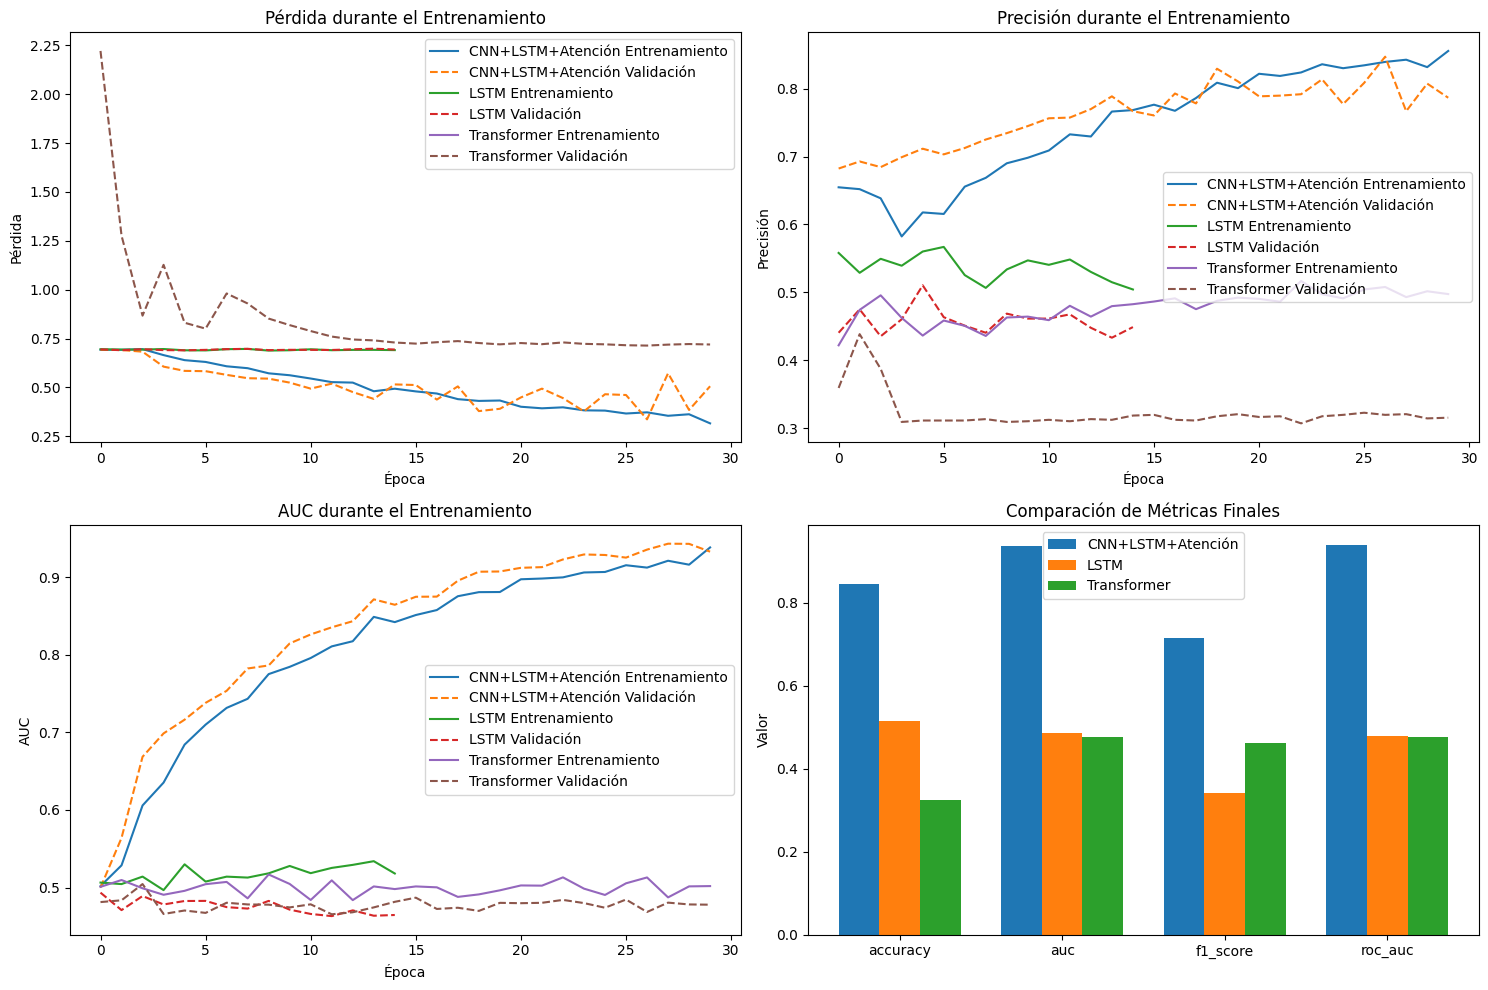

In [ ]:
# Visualización de resultados
plt.figure(figsize=(15, 10))

# Pérdida
plt.subplot(2, 2, 1)
for model_name, result in results.items():
    plt.plot(result['history']['loss'], label=f'{model_name} Entrenamiento')
    plt.plot(result['history']['val_loss'], label=f'{model_name} Validación', linestyle='--')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(2, 2, 2)
for model_name, result in results.items():
    plt.plot(result['history']['accuracy'], label=f'{model_name} Entrenamiento')
    plt.plot(result['history']['val_accuracy'], label=f'{model_name} Validación', linestyle='--')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# AUC
plt.subplot(2, 2, 3)
for model_name, result in results.items():
    plt.plot(result['history']['auc'], label=f'{model_name} Entrenamiento')
    plt.plot(result['history']['val_auc'], label=f'{model_name} Validación', linestyle='--')
plt.title('AUC durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('AUC')
plt.legend()

# Comparación de métricas finales
plt.subplot(2, 2, 4)
metrics = ['accuracy', 'auc', 'f1_score', 'roc_auc']
x = np.arange(len(metrics))
width = 0.25
for i, (model_name, result) in enumerate(results.items()):
    metric_values = [result[m] for m in metrics]
    plt.bar(x + i*width, metric_values, width, label=model_name)
plt.title('Comparación de Métricas Finales')
plt.xticks(x + width, metrics)
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

## Conclusiones

###  Análisis comparativo y conclusión sobre los resultados

Se evaluaron tres arquitecturas distintas sobre el problema de clasificación de actividad cerebral dañina (EEG), utilizando métricas estándar como Accuracy, AUC, F1-Score y AUC-ROC.

### Resultados por modelo

| Modelo                    | Accuracy | AUC    | F1-Score | AUC-ROC |
|---------------------------|----------|--------|----------|---------|
| CNN+LSTM+Atención         | 0.8458   | 0.9354 | 0.7151   | 0.9396  |
| LSTM (solo)               | 0.5146   | 0.4852 | 0.3413   | 0.4777  |
| Transformer (básico)      | 0.3240   | 0.4751 | 0.4615   | 0.4761  |

### Interpretación

- El modelo **CNN+LSTM+Atención** mostró una **clara superioridad** en todas las métricas. Esto se alinea con su capacidad de extraer características espaciales (CNN), temporales (LSTM), y ponderar la importancia de las secuencias (Atención).
- El modelo **LSTM puro**, aunque más simple, logró superar la aleatoriedad (50%) solo marginalmente, indicando que la información secuencial por sí sola **no es suficiente** tras la reducción de dimensionalidad.
- El modelo **Transformer** básico mostró desempeño más bajo, posiblemente por su sensibilidad al volumen de datos o a la falta de preentrenamiento o tuning más profundo.

### Conclusión

El modelo híbrido **CNN+LSTM+Atención** se posiciona como la arquitectura más robusta y eficaz para esta tarea, logrando un **AUC de 0.93** y una precisión cercana al 85%. Esto valida la importancia de combinar estructuras convolucionales y recurrentes con mecanismos de atención para el análisis de señales EEG complejas. Modelos más simples o arquitecturas Transformer sin optimización no logran capturar suficientemente la dinámica multicanal y temporal de los datos.

Por lo tanto, para despliegues prácticos o investigaciones futuras, se recomienda seguir explorando variantes de modelos híbridos, incorporando atención o autoatención con mayor profundidad y arquitectura optimizada.

